In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
def accuracy_plot(model, title): 
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def loss_plot(model, title): 
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
# plotting

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def confusion_plot(y_true_labels, y_pred_labels, title, class_names): 

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("All data confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                          title=title)

    plt.show()
    
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=title)

    plt.show()

In [3]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [4]:
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [5]:
train_df.columns

Index(['index', 'Unnamed: 0', 'Unnamed: 0.1', 'On-Target Site',
       'Off-Target Site', 'Score', 'Encoded Seqs'],
      dtype='object')

In [6]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [7]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())
alph_len = len(new_alph)

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
# one-hot encode
def _get_one_hot_encoding(seq):
  """Generate one-hot encoding for a single nucleotide sequence."""
  return pd.get_dummies(
      list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)
train_data_f = np.reshape(train_data, (-1, alph_len * seq_len))
#val_data_f = np.reshape(val_data, (-1, alph_len * seq_len))
test_data_f = np.reshape(test_data, (-1, alph_len * seq_len))

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [8]:
alph_len = len(new_alph)

from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [9]:
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD

# new metrics from: http://www.deepideas.net/unbalanced-classes-machine-learning/
from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [10]:
from sklearn.linear_model import LogisticRegressionCV
X = train_data_f
y = np.array(train_df[output_bin_col_name].astype(np.float32))
model = LogisticRegressionCV(cv=5, random_state=0, verbose=3).fit(X, y)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Us

In [11]:
X_new = test_data_f
y_true = np.array(test_df[output_bin_col_name].astype(np.float32))
preds = model.predict(X_new)

AUC: 0.5
Accuracy: 0.9979249060104487 

F1: 0.49948068769168735 

Confusion matrix, without normalization
[[81754     0]
 [  170     0]]


/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


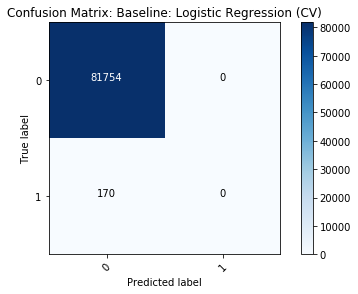

All data confusion matrix
[[1. 0.]
 [1. 0.]]


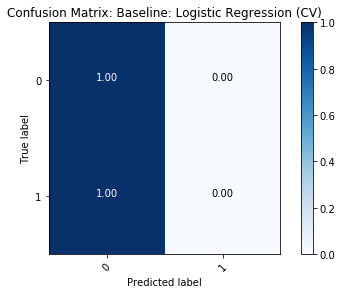

In [12]:
specs = 'Baseline: Logistic Regression (CV)'

# X_new = test_data
# y_true = test_bins
# y_pred = model.predict(X_new)

#y_true_labels = np.argmax(y_true, axis=1)
#y_pred_labels = np.argmax(y_pred, axis=1) 
from sklearn.metrics import roc_auc_score
y_true_labels= np.array(test_df[output_bin_col_name].astype(np.float32))
y_pred_labels = preds
print('AUC:', roc_auc_score(y_true_labels, y_pred_labels))

print('Accuracy:', sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels), '\n')
print('F1:', sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro'),'\n')

#accuracy_plot(model, 'Accuracy: ' + specs)
#loss_plot(model, 'Loss: ' + specs)

class_names = ['0', '1']
confusion_plot(y_true_labels, y_pred_labels, 'Confusion Matrix: ' + specs, class_names)

In [13]:
# from TAs on piazza: use precision-recall, ROC can be misleading 
# modified code from sklearn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# and referenced: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_true, y_pred_labels)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.00


In [14]:
from sklearn.metrics import recall_score, precision_score

print('Recall:', recall_score(y_true_labels, y_pred_labels))
print('Precision:', precision_score(y_true_labels, y_pred_labels))

Recall: 0.0
Precision: 0.0


/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
